**Problem and motivation**
Motivation and Problem: Our client is a food publication company that has a lot of recipes. These recipes are supplied as lists of ingredients. We need users to be able to query recipes by cuisine.

**The data** More than 39,000 recipe ingredient lists, no labels.

**The task** Group recipes by cuisine.

**The model**: I used k-means clustering to cluster recipes into 15 cuisines. I then used a logistic regression (with clusters as labels) to identify the ingredients that predict each cluster. 6 of these clusters binned into 4 cuisines: 2 Italian, 2 Asian, 1 Mexican and 1 Indian cluster. 2 clusters represented baking recipes. 7 clusters were difficul to assign to cuisines. 

**Outstanding challenges**: Ingredient list currently includes "descriptive" words, making similar ingredients be seen as two distinct ingredients. The first thing to do next would be to clean up this list. Next, I would cluster by 2 clusters. The first two clusters separate savory vs. baked. I would then cluster the savory recipes only, and potentially use fewer clusters since the same cuisines appear in distinct clusters above. 


In [17]:
#Load necessary packages
import os
import pandas as pd
import copy
from collections import Counter 

#Import sklearn models
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

#Import matplotlib
import matplotlib.pyplot as plt

from ast import literal_eval

In [79]:
import sys
print(sys.path)

['', '//anaconda/envs/py36/lib/python36.zip', '//anaconda/envs/py36/lib/python3.6', '//anaconda/envs/py36/lib/python3.6/lib-dynload', '//anaconda/envs/py36/lib/python3.6/site-packages', '//anaconda/envs/py36/lib/python3.6/site-packages/aeosa', '//anaconda/envs/py36/lib/python3.6/site-packages/IPython/extensions', '/Users/Olga/.ipython']


In [18]:
os.chdir("/Users/Olga/Documents/INSIGHT2019/DataChallenge/Week6/")
recipes_DF = pd.read_json('unlabelled_recipies.json')

In [19]:
#Look at data
print(recipes_DF.shape)
recipes_DF = recipes_DF.reset_index(drop = True)
print(recipes_DF.head(10))

(39774, 1)
                                         ingredients
0  [pepper, bacon, russet potatoes, sugar, onions...
1  ['rib', 'carrots', 'leeks', 'unsalted butter',...
2  [orzo, garlic, heavy cream, white wine, spinac...
3  ['garlic', 'ginger', 'fish sauce', 'chayotes',...
4  [onions, avocado, salt, coconut cream, cumin s...
5  [salt, onion salt, paprika, ground cumin, dice...
6  [fennel seeds, sugar cane juice, ice, thai bas...
7  [hot water, part-skim ricotta cheese, provolon...
8  [lemon juice, salt, egg whites, milk, egg yolk...
9  ['sambal ulek', 'brown sugar', 'peeled fresh g...


### Data clean up: convert ingredients written as strings to list of strings

In [20]:
#Note that some entries are list of strings and some entries are just strings
print(type(recipes_DF.iloc[0, 0]))
print(type(recipes_DF.iloc[1, 0]))
print(recipes_DF.iloc[0, 0][0])
print(recipes_DF.iloc[1, 0][0])

<class 'list'>
<class 'str'>
pepper
[


In [21]:
#convert to list, then to string
recipes_DF['ingredients']= recipes_DF['ingredients'].astype(str).apply(literal_eval)

In [22]:
#Number of ingredients

In [23]:
list_of_ingredients = []
for i in range(recipes_DF.shape[0]):
    list_of_ingredients.append(recipes_DF.iloc[i,0])

flat_list = [item for sublist in list_of_ingredients for item in sublist]

from collections import Counter
ing_occurance = pd.DataFrame(Counter(flat_list).most_common(7000), columns = ["ingredient", "timespresent"])

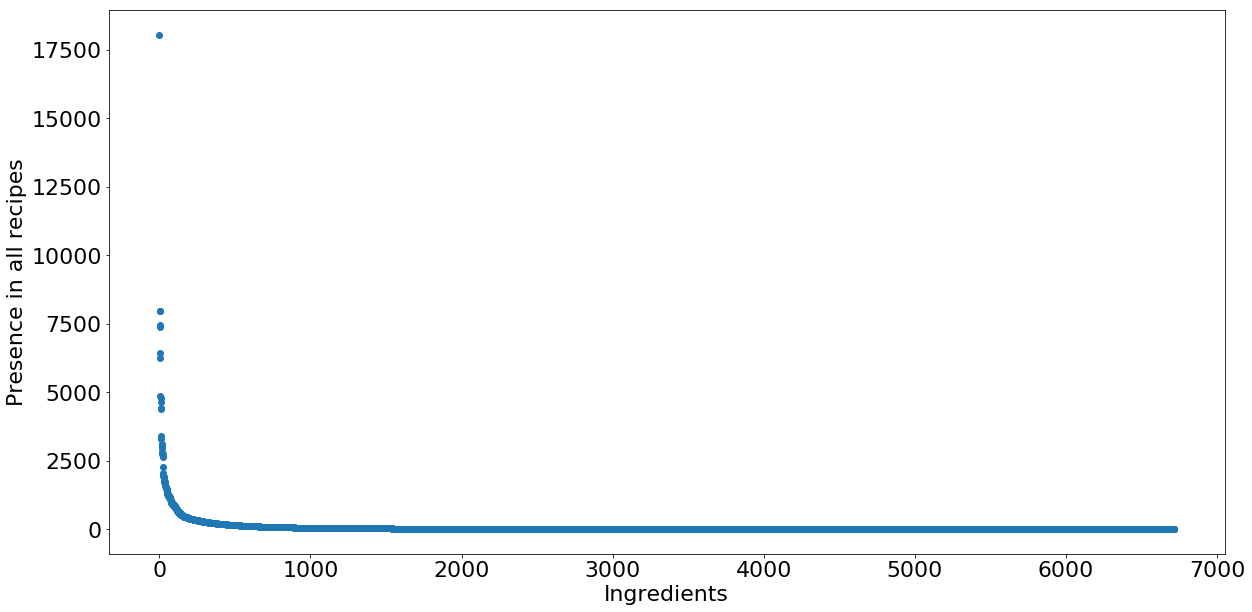

In [24]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(20,10))
plt.scatter(list(range(1, ing_occurance.shape[0]+1,  1)), ing_occurance.timespresent)
plt.ylabel("Presence in all recipes")
plt.xlabel("Ingredients")
plt.show()

### Data Transformation #1: one hot encode ingredients

In [25]:
recipes_DF_onehot = copy.deepcopy(recipes_DF)
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
recipes_DF_onehot = recipes_DF_onehot.join(pd.DataFrame(mlb.fit_transform(recipes_DF_onehot.pop('ingredients')),
                          columns=mlb.classes_,
                          index=recipes_DF_onehot.index))

In [26]:
recipes_DF_onehot.head(10)

,( oz.) tomato sauce,( oz.) tomato paste,(10 oz.) frozen chopped spinach,"(10 oz.) frozen chopped spinach, thawed and squeezed dry",(14 oz.) sweetened condensed milk,(14.5 oz.) diced tomatoes,(15 oz.) refried beans,1% low-fat buttermilk,1% low-fat chocolate milk,1% low-fat cottage cheese,...,yukon gold potatoes,yuzu,yuzu juice,za'atar,zest,zesty italian dressing,zinfandel,ziti,zucchini,zucchini blossoms
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Data transformation #2: Remove ingredients that come up very few times from one-hot-encoded set.
<p>One GLARING issue here is that a lot of ingredients are super specific (i.e. "(10 oz.) frozen chopped spinach, thawed and squeezed dry").</p><p>Ideally, I would combine i.e. all spinach into single ingredient, regardless of adjectives. <p>On first pass though, I will just remove those ingredients that show up in less than 1% of recipes.</p>

In [27]:
cols_to_drop = []
for col in recipes_DF_onehot.columns:
    if recipes_DF_onehot[col].sum() < 0.01*recipes_DF_onehot.shape[0]:
            cols_to_drop.append(col)

In [28]:
print("Original # of columns:", len(recipes_DF_onehot.columns))
print("Columns to drop:", len(cols_to_drop))
print("Total columns left:", len(recipes_DF_onehot.columns) - len(cols_to_drop))

Original # of columns: 6714
Columns to drop: 6520
Total columns left: 194


In [29]:
recipes_DF_onehot_194COLS = recipes_DF_onehot.drop(cols_to_drop, axis = 1)
recipes_DF_onehot_194COLS.shape

(39774, 194)

In [30]:
recipes_DF_onehot_194COLS.head(10)

,all-purpose flour,avocado,bacon,baking powder,baking soda,balsamic vinegar,bay leaf,bay leaves,beansprouts,black beans,...,water,whipping cream,white onion,white pepper,white sugar,white vinegar,whole milk,worcestershire sauce,yellow onion,zucchini
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Data Transformation #3: TF-IDF Ingredients (weight by frequency)
I had done this initially, but actually I don't think it makes sense given that for most recipes, each ingredient only comes up ONCE. So effectively TF-IDF would just end up dividing the whole colmn in DF above. Also, TF-IDF vectorizes words,and I can't figure out how to make it vectorize ingredients separated by commas so this is not ideal either. 

In [31]:
recipes_DF['ing_as_str'] = ""
for i in range(recipes_DF.shape[0]):
    recipes_DF.iloc[i,1] = ','.join(recipes_DF.iloc[i,0])
    if i%10000 == 0:
        print(i)

0
10000
20000
30000


In [32]:
list_of_recipe_strings = []
for i in range(recipes_DF.shape[0]):
    list_of_recipe_strings.append(recipes_DF.iloc[i,1])

In [33]:
# tokenize and build vocab
vectorizer = TfidfVectorizer()
vectorizer.fit(list_of_recipe_strings)
# summarize
print(vectorizer.vocabulary_)
print(vectorizer.idf_)
# encode document
vector = vectorizer.transform(list_of_recipe_strings)
# summarize encoded vector
print(vector.shape)
print(vector.toarray())

{'pepper': 1998, 'bacon': 139, 'russet': 2328, 'potatoes': 2125, 'sugar': 2647, 'onions': 1873, 'gochugaru': 1137, 'olive': 1867, 'oil': 1860, 'shredded': 2470, 'cheddar': 517, 'cheese': 522, 'kimchi': 1438, 'scallions': 2387, 'salt': 2349, 'rib': 2256, 'carrots': 462, 'leeks': 1513, 'unsalted': 2855, 'butter': 375, 'finely': 981, 'chopped': 577, 'onion': 1872, 'baking': 148, 'dry': 868, 'white': 2943, 'wine': 2954, 'half': 1229, 'water': 2922, 'bay': 180, 'leaf': 1505, 'dried': 861, 'thyme': 2747, 'chicken': 536, 'broth': 348, 'saffron': 2337, 'threads': 2746, 'orzo': 1890, 'garlic': 1094, 'heavy': 1261, 'cream': 708, 'spinach': 2567, 'eggs': 898, 'breasts': 330, 'parmesan': 1947, 'bread': 320, 'crumbs': 739, 'crushed': 743, 'red': 2238, 'ginger': 1118, 'fish': 990, 'sauce': 2374, 'chayotes': 516, 'cooking': 671, 'meat': 1667, 'avocado': 130, 'coconut': 626, 'cumin': 763, 'seed': 2411, 'tumeric': 2820, 'chile': 545, 'powder': 2133, 'daal': 783, 'garam': 1087, 'masala': 1645, 'grated':

(39774, 3010)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### K means cluster on one hot encoded data
I have 2 primary datasets to work with: recipes_DF_onehot and recipes_DF_onehot_194COLS

In [34]:
#K-means on reduced dataset
kmeans_194 = KMeans(n_clusters=15, random_state=0)
kmeans_194.fit(recipes_DF_onehot_194COLS)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=15, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [35]:
#PCA and k-means on original data set
#Need to use PCA first to speed up clustering
pca = PCA(n_components = 100)
recipes_DF_onehot_100PCs = pca.fit_transform(recipes_DF_onehot)

In [36]:
kmeans_all = KMeans(n_clusters=15, random_state=0)
kmeans_all.fit(recipes_DF_onehot_100PCs)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=15, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

### Which are the most important features for each cluster?

In [37]:
recipes_DF_onehot_194COLS_wlabels = copy.deepcopy(recipes_DF_onehot_194COLS)
recipes_DF_onehot_194COLS_wlabels['Cluster'] = kmeans_194.labels_
recipes_DF_onehot_wlabels = copy.deepcopy(recipes_DF_onehot)
recipes_DF_onehot_wlabels['Cluster'] = kmeans_all.labels_

#### Logistics regression on both datasets

In [38]:
### Logistic regression with 194 labels, train-test split
#Model is not overfit
LogModel2 = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(recipes_DF_onehot_194COLS, kmeans_194.labels_, test_size=0.33, random_state=42)
LogModel2.fit(X_train, y_train)
print(LogModel2.score(X_train, y_train))
print(LogModel2.score(X_test, y_test))

0.9789102371660162
0.9680786225811366


In [39]:
print(metrics.precision_score(LogModel2.predict(X_test), y_test, average = 'macro'))
print(metrics.recall_score(LogModel2.predict(X_test), y_test, average = 'macro'))

0.9622824869714854
0.9654778090347609


In [40]:
recipes_DF_onehot_194COLS_withclustes = pd.DataFrame(LogModel2.coef_)
recipes_DF_onehot_194COLS_withclustes.columns = recipes_DF_onehot_194COLS.columns
recipes_DF_onehot_194COLS_withclustes.head()

recipes_DF_onehot_194COLS_withclustes_transposed = recipes_DF_onehot_194COLS_withclustes.T
recipes_DF_onehot_194COLS_withclustes_transposed.reset_index(inplace=True)
recipes_DF_onehot_194COLS_withclustes_transposed.head()

,index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,all-purpose flour,-1.043383,-4.339468,7.150453,-2.854586,-0.632802,-0.628541,-0.501929,-1.254295,-0.236907,0.010830,-0.229081,-1.699682,-4.300011,-0.410194,-1.171619
1,avocado,0.088751,0.245999,-0.393454,0.186757,0.027897,0.022251,-0.837285,-0.062523,-0.010781,-0.067397,0.334071,-0.942490,0.160127,0.738892,-0.822599
2,bacon,0.613710,-0.600350,-0.009586,0.690984,-0.013161,0.195461,0.082920,-0.105939,-0.346142,-0.140176,-0.074865,-0.330628,0.087617,0.251095,-0.799765
3,baking powder,-0.897073,-1.620144,4.000767,-2.802689,-1.023229,-1.690429,-0.596834,-1.181964,-0.594189,-2.203344,-0.887324,-1.181324,-1.798544,-1.240099,-0.290570
4,baking soda,-0.398262,-0.994949,2.321313,-0.914619,-0.778223,-1.057288,-0.031160,-0.743603,-0.445268,-0.610990,-0.778176,-0.196698,-1.447590,-1.047842,0.004416


In [41]:
#FEATURE IMPORTANCE IN EACH RECIPE
recipes_DF_onehot_194COLS_withclustes.T.loc[:, 6].sort_values(ascending = False)

#FEATURE IMPORTANCE IN EACH RECIPE
#recipes_DF_onehot_feat_imp = pd.DataFrame(index = recipes_DF_onehot_withclustes_transposed.index)
recipes_DF_onehot_194COLS_feat_imp = pd.DataFrame()
for i in range(0, 15, 1):
    a = recipes_DF_onehot_194COLS_withclustes_transposed.loc[:, ["index", i]].sort_values(by = i, ascending = False, inplace = False)
    name1 = "index" + str(i)
    name2 = "Cluster" + str(i)
    recipes_DF_onehot_194COLS_feat_imp[name1] = list(a.iloc[:, 0])
    recipes_DF_onehot_194COLS_feat_imp[name2] = list(a.iloc[:, 1])

In [42]:
recipes_DF_onehot_194COLS_feat_imp

,index0,Cluster0,index1,Cluster1,index2,Cluster2,index3,Cluster3,index4,Cluster4,...,index10,Cluster10,index11,Cluster11,index12,Cluster12,index13,Cluster13,index14,Cluster14
0,garlic cloves,9.857900,sugar,10.162260,all-purpose flour,7.150453,bacon,0.690984,olive oil,9.125877,...,garlic,9.365908,water,9.829040,salt,9.142145,kosher salt,10.037214,soy sauce,7.806094
1,extra-virgin olive oil,2.910415,chopped celery,1.043178,baking powder,4.000767,low sodium soy sauce,0.637759,salt,8.689363,...,salt,6.619052,sugar,1.050172,pepper,1.470850,ground black pepper,4.310071,sesame oil,4.691393
2,salt,1.710382,flour,0.911936,salt,3.118859,hot sauce,0.559560,garlic cloves,2.761514,...,pepper,2.604417,fresh mint,1.037381,oil,0.898097,extra-virgin olive oil,1.472193,garlic,3.082199
3,cinnamon,0.890368,bay leaves,0.890276,unsalted butter,2.702148,shredded cheddar cheese,0.534557,pepper,0.703466,...,onions,1.163928,low sodium soy sauce,0.909362,green chilies,0.884580,chopped onion,0.976284,green onions,2.782974
4,large shrimp,0.839483,fish sauce,0.704304,large eggs,2.645212,chopped celery,0.481976,fresh cilantro,0.535898,...,curry powder,0.904403,white vinegar,0.829431,mayonaise,0.673740,avocado,0.738892,rice vinegar,2.273585
5,eggplant,0.799429,hot sauce,0.666680,baking soda,2.321313,shredded mozzarella cheese,0.466471,warm water,0.530096,...,tomatoes,0.797348,fish sauce,0.789154,potatoes,0.654446,ketchup,0.737532,scallions,2.161987
6,dried basil,0.764314,whipping cream,0.567843,butter,2.053443,mayonaise,0.464672,fat free less sodium chicken broth,0.529638,...,cilantro,0.726461,mirin,0.725497,mirin,0.626920,coriander,0.718795,corn starch,2.105960
7,fresh mint,0.720376,freshly ground pepper,0.558992,buttermilk,1.744557,cream cheese,0.447201,egg yolks,0.502103,...,cinnamon sticks,0.582208,warm water,0.621007,curry powder,0.610901,garlic cloves,0.709417,ginger,2.053785
8,fat free less sodium chicken broth,0.668027,egg yolks,0.553187,vanilla extract,1.473809,garlic powder,0.431849,black pepper,0.377209,...,chili powder,0.536937,white onion,0.539511,black pepper,0.583067,low sodium soy sauce,0.704832,fresh ginger,1.456320
9,low sodium soy sauce,0.619841,flat leaf parsley,0.548587,milk,1.453105,ground ginger,0.417390,spring onions,0.346972,...,low sodium soy sauce,0.506316,worcestershire sauce,0.527374,cooking spray,0.524485,chopped cilantro fresh,0.659383,vegetable broth,1.168514


********************

In [43]:
### Logistic regression with all labels, train-test split
#Model is not overfit
LogModel3 = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(recipes_DF_onehot, kmeans_all.labels_, test_size=0.33, random_state=42)
LogModel3.fit(X_train, y_train)
print(LogModel3.score(X_train, y_train))
print(LogModel3.score(X_test, y_test))

0.9927199039327529
0.9569556605211031


In [44]:
print(metrics.precision_score(LogModel3.predict(X_test), y_test, average = 'macro'))
print(metrics.recall_score(LogModel3.predict(X_test), y_test, average = 'macro'))

0.9453025936163628
0.9536875633674443


In [45]:
recipes_DF_onehot_withclustes = pd.DataFrame(LogModel3.coef_)
recipes_DF_onehot_withclustes.columns = recipes_DF_onehot.columns
recipes_DF_onehot_withclustes.head()

recipes_DF_onehot_withclustes_transposed = recipes_DF_onehot_withclustes.T
recipes_DF_onehot_withclustes_transposed.reset_index(inplace=True)
recipes_DF_onehot_withclustes_transposed.head()

,index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,( oz.) tomato sauce,-3.481467e-03,-3.984811e-03,-0.012966,-0.001341,-0.207122,-0.013536,-0.309341,-3.318599e-05,0.022629,-0.292786,0.087535,-0.001084,-0.147790,-0.000208,-0.003151
1,( oz.) tomato paste,-1.562339e-01,-4.661164e-03,0.239538,-0.593588,-0.008037,-0.010584,0.082697,2.968229e-01,0.317642,-0.004398,-0.019338,-0.022091,-0.363556,-0.000143,-0.032675
2,(10 oz.) frozen chopped spinach,-8.254743e-07,-8.565169e-07,-0.000006,-0.000008,-0.004065,-0.001355,-0.000055,-5.006873e-07,-0.000071,-0.000002,-0.011940,-0.000007,0.021266,-0.000035,-0.000034
3,"(10 oz.) frozen chopped spinach, thawed and sq...",0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,(14 oz.) sweetened condensed milk,-2.316613e-03,-2.236340e-03,-0.056442,-0.001302,0.004457,-0.000550,-0.000504,1.252827e-03,-0.000125,-0.000028,-0.000009,-0.000152,-0.001529,-0.000150,-0.002554


In [46]:
#FEATURE IMPORTANCE IN EACH RECIPE
#recipes_DF_onehot_feat_imp = pd.DataFrame(index = recipes_DF_onehot_withclustes_transposed.index)
recipes_DF_onehot_feat_imp = pd.DataFrame()
for i in range(0, 15, 1):
    a = recipes_DF_onehot_withclustes_transposed.loc[:, ["index", i]].sort_values(by = i, ascending = False, inplace = False)
    name1 = "index" + str(i)
    name2 = "Cluster" + str(i)
    recipes_DF_onehot_feat_imp[name1] = list(a.iloc[:, 0])
    recipes_DF_onehot_feat_imp[name2] = list(a.iloc[:, 1])

In [47]:
recipes_DF_onehot_feat_imp

,index0,Cluster0,index1,Cluster1,index2,Cluster2,index3,Cluster3,index4,Cluster4,...,index10,Cluster10,index11,Cluster11,index12,Cluster12,index13,Cluster13,index14,Cluster14
0,salt,9.005009,water,9.776401,sugar,10.991955,extra-virgin olive oil,9.871560,cornmeal,1.084647,...,garlic,8.347936,garam masala,3.462707,olive oil,10.304824,soy sauce,8.158554,sour cream,6.678315
1,cooked chicken breasts,1.146603,instant rice,1.330412,asian fish sauce,1.145684,garlic cloves,1.635625,lump crab meat,0.995341,...,onions,8.087882,ground turmeric,3.306918,tortilla chips,1.070118,sesame oil,3.817215,salsa,4.096347
2,chile pepper,0.923124,scallion greens,1.254189,plain flour,1.005039,semolina flour,1.029871,Pace Picante Sauce,0.959774,...,curry powder,0.929007,cumin seed,2.978864,ground ginger,0.949736,green onions,2.254827,flour tortillas,3.159171
3,chili flakes,0.899265,chutney,1.210414,rice cakes,0.984031,freshly ground pepper,1.015499,minute rice,0.899120,...,mexican chorizo,0.887879,green chilies,2.519743,marjoram,0.892012,scallions,2.235490,shredded cheddar cheese,2.153836
4,chutney,0.898761,light coconut milk,1.165871,chopped celery,0.968447,flat leaf parsley,0.983859,ground pork,0.864902,...,spring onions,0.806986,onions,2.132495,chickpeas,0.884528,corn starch,2.080107,corn tortillas,1.524006
5,finely chopped fresh parsley,0.865974,ancho chile pepper,1.157298,tomato ketchup,0.963298,ground black pepper,0.976868,chili,0.863180,...,walnut oil,0.781779,oil,1.848480,onion soup mix,0.856344,ginger,1.855407,picante sauce,1.442097
6,cilantro sprigs,0.857398,sesame,1.137659,plums,0.936218,fresh lemon juice,0.967484,processed cheese,0.859907,...,leaves,0.695435,chili powder,1.828844,coconut cream,0.824031,garlic,1.820852,taco seasoning,1.398534
7,light soy sauce,0.851445,jasmine rice,1.110421,anise seed,0.929282,greens,0.788781,bread crumb fresh,0.857430,...,elbow macaroni,0.675177,tomatoes,1.762607,brisket,0.813838,fresh ginger,1.769093,green onions,1.361877
8,kalamata,0.849530,miso,1.061833,chicken tenderloin,0.925219,cannellini beans,0.666050,round steaks,0.854900,...,taco sauce,0.673795,ginger,1.678310,soft goat's cheese,0.780981,rice vinegar,1.674358,tomatoes,1.278599
9,light cream,0.845077,medium shrimp,1.012454,ground chicken,0.895694,goat cheese,0.653560,Dutch-processed cocoa powder,0.842980,...,anise seed,0.653166,cilantro leaves,1.617308,dried porcini mushrooms,0.768545,carrots,1.216340,black beans,1.245276


In [48]:
##Compare featues
for i in range(0, recipes_DF_onehot_feat_imp.shape[1], 2):
    print(recipes_DF_onehot_feat_imp.iloc[0:15, i])

0                             salt
1           cooked chicken breasts
2                     chile pepper
3                     chili flakes
4                          chutney
5     finely chopped fresh parsley
6                  cilantro sprigs
7                  light soy sauce
8                         kalamata
9                      light cream
10                   spanish onion
11                boneless chicken
12                mixed vegetables
13          vegetable stock powder
14                 medium tomatoes
Name: index0, dtype: object
0                  water
1           instant rice
2        scallion greens
3                chutney
4     light coconut milk
5     ancho chile pepper
6                 sesame
7           jasmine rice
8                   miso
9          medium shrimp
10          minced onion
11         glass noodles
12       catfish fillets
13    japanese eggplants
14        polish sausage
Name: index1, dtype: object
0                    sugar
1         asian f

In [49]:
for i in range(0, recipes_DF_onehot_194COLS_feat_imp.shape[1], 2):
    print(recipes_DF_onehot_194COLS_feat_imp.iloc[0:15, i])

0                          garlic cloves
1                 extra-virgin olive oil
2                                   salt
3                               cinnamon
4                           large shrimp
5                               eggplant
6                            dried basil
7                             fresh mint
8     fat free less sodium chicken broth
9                   low sodium soy sauce
10                                 bacon
11                                capers
12                           fresh basil
13                              sea salt
14                         cooking spray
Name: index0, dtype: object
0                     sugar
1            chopped celery
2                     flour
3                bay leaves
4                fish sauce
5                 hot sauce
6            whipping cream
7     freshly ground pepper
8                 egg yolks
9         flat leaf parsley
10           fresh rosemary
11             white pepper
12                  c

### K means cluster on one hot encoded data using original data set, but asking for fewer clusters

In [50]:
#PCA and k-means on original data set
#Need to use PCA first to speed up clustering
kmeans_all = KMeans(n_clusters=10, random_state=0)
kmeans_all.fit(recipes_DF_onehot_100PCs)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [51]:
recipes_DF_onehot_10CLUSTERS_wlabels = copy.deepcopy(recipes_DF_onehot)
recipes_DF_onehot_10CLUSTERS_wlabels['Cluster'] = kmeans_all.labels_

In [52]:
### Logistic regression with all labels, train-test split
#Model is not overfit
LogModel4 = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(recipes_DF_onehot, kmeans_all.labels_, test_size=0.33, random_state=42)
LogModel4.fit(X_train, y_train)
print(LogModel4.score(X_train, y_train))
print(LogModel4.score(X_test, y_test))

0.9957220054037826
0.9682309919244249


In [53]:
print(metrics.precision_score(LogModel4.predict(X_test), y_test, average = 'macro'))
print(metrics.recall_score(LogModel4.predict(X_test), y_test, average = 'macro'))

0.9558701627850914
0.9640177609776718


In [54]:
recipes_DF_onehot_withclustes_10CS = pd.DataFrame(LogModel4.coef_)
recipes_DF_onehot_withclustes_10CS.columns = recipes_DF_onehot.columns
recipes_DF_onehot_withclustes_10CS.head()

recipes_DF_onehot_withclustes_10CS_transposed = recipes_DF_onehot_withclustes_10CS.T
recipes_DF_onehot_withclustes_10CS_transposed.reset_index(inplace=True)
recipes_DF_onehot_withclustes_10CS_transposed.head()

,index,0,1,2,3,4,5,6,7,8,9
0,( oz.) tomato sauce,0.008913,-0.007181,0.015223,-0.000306,-0.005981,-0.004210,-0.000335,-0.007074,-0.175724,-3.514378e-05
1,( oz.) tomato paste,0.031090,0.018901,0.003155,-0.000115,0.100200,-0.006036,0.571875,-0.028883,-0.011979,-3.828403e-02
2,(10 oz.) frozen chopped spinach,-0.000001,-0.000009,0.009426,-0.000021,-0.000011,-0.000017,-0.042011,-0.000004,-0.000850,-5.270679e-07
3,"(10 oz.) frozen chopped spinach, thawed and sq...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
4,(14 oz.) sweetened condensed milk,-0.000436,-0.105375,-0.001141,-0.000165,-0.001639,-0.000160,-0.000013,-0.000152,0.002993,1.710073e-03


In [55]:
#FEATURE IMPORTANCE IN EACH RECIPE
#recipes_DF_onehot_feat_imp = pd.DataFrame(index = recipes_DF_onehot_withclustes_transposed.index)
recipes_DF_onehot_10PC_feat_imp = pd.DataFrame()
for i in range(0, 10, 1):
    a = recipes_DF_onehot_withclustes_10CS_transposed.loc[:, ["index", i]].sort_values(by = i, ascending = False, inplace = False)
    name1 = "index" + str(i)
    name2 = "Cluster" + str(i)
    recipes_DF_onehot_10PC_feat_imp[name1] = list(a.iloc[:, 0])
    recipes_DF_onehot_10PC_feat_imp[name2] = list(a.iloc[:, 1])
    

In [56]:
recipes_DF_onehot_10PC_feat_imp

,index0,Cluster0,index1,Cluster1,index2,Cluster2,index3,Cluster3,index4,Cluster4,index5,Cluster5,index6,Cluster6,index7,Cluster7,index8,Cluster8,index9,Cluster9
0,salt,10.551900,sugar,11.392647,olive oil,9.771645,soy sauce,8.675717,butter,10.359164,garlic cloves,11.611221,garlic,9.996477,garam masala,3.581191,canned tomatoes,1.006427,all-purpose flour,7.428588
1,semolina flour,1.294451,bread flour,1.319893,fennel,1.015662,sesame oil,3.782338,flour,1.347610,olive oil,2.197264,salt,5.006002,ground turmeric,3.392739,sherry,0.942354,baking powder,4.444082
2,pepper,1.282865,gari,1.128028,large garlic cloves,0.905861,corn starch,2.211442,cake flour,1.334889,extra-virgin olive oil,1.357698,onions,2.533163,cumin seed,3.250090,mochi,0.922322,salt,3.165435
3,olive oil,1.162035,chicken pieces,1.104771,reduced fat Mexican cheese,0.757831,green onions,1.970062,goat cheese,1.258470,brown mustard seeds,1.052821,pepper,1.552279,green chilies,2.711206,palm sugar,0.884473,large eggs,3.034331
4,crushed garlic,1.057412,five spice,1.099626,fresh marjoram,0.717075,scallions,1.956837,reduced fat milk,1.249338,tomatillos,0.973534,sweet rice flour,1.144593,onions,2.340933,coarse sea salt,0.883042,unsalted butter,2.833128
5,fat free yogurt,1.002516,asian fish sauce,1.072219,kosher salt,0.716407,ginger,1.876091,dark corn syrup,1.146233,palm sugar,0.970396,dried apricot,1.134409,oil,2.223654,nonfat yogurt plain,0.822018,buttermilk,2.156826
6,nigella seeds,0.989487,shallots,1.006765,salt and ground black pepper,0.631821,rice vinegar,1.798646,pecans,1.137212,garbanzo beans,0.928656,beef bouillon granules,1.057042,ginger,2.072541,black sesame seeds,0.808645,sugar,2.070479
7,self rising flour,0.889529,low sodium soy sauce,0.983420,jumbo pasta shells,0.619376,fresh ginger,1.728418,french bread,1.119624,allspice,0.869692,cauliflower florets,1.052505,tomatoes,1.894321,chicken fingers,0.775927,baking soda,2.024644
8,white cornmeal,0.835814,red lentils,0.929325,tortillas,0.589148,vegetable oil,1.554147,rosemary leaves,1.101199,frozen spinach,0.866689,nonfat yogurt plain,1.016453,tumeric,1.871538,salted butter,0.756769,vanilla extract,1.830463
9,frozen whole kernel corn,0.835221,chicken tenderloin,0.911146,fresh thyme,0.573718,garlic,1.551449,sliced almonds,1.070282,fresh lemon juice,0.849799,reduced sodium chicken broth,0.968463,chili powder,1.837986,beef stock,0.734806,granulated sugar,1.609701


In [57]:
for i in range(0, recipes_DF_onehot_10PC_feat_imp.shape[1], 2):
    print(recipes_DF_onehot_10PC_feat_imp.iloc[0:15, i])

0                                    salt
1                          semolina flour
2                                  pepper
3                               olive oil
4                          crushed garlic
5                         fat free yogurt
6                           nigella seeds
7                       self rising flour
8                          white cornmeal
9                frozen whole kernel corn
10                                  ravva
11    shredded reduced fat cheddar cheese
12                     Turkish bay leaves
13                       chicken bouillon
14                          garlic powder
Name: index0, dtype: object
0                    sugar
1              bread flour
2                     gari
3           chicken pieces
4               five spice
5         asian fish sauce
6                 shallots
7     low sodium soy sauce
8              red lentils
9       chicken tenderloin
10              fish sauce
11         chicken fillets
12        black te

### Use different metric with one hot encoded, 15 cluster

In [58]:
recipes_DF_onehot_wlabels.head()

,( oz.) tomato sauce,( oz.) tomato paste,(10 oz.) frozen chopped spinach,"(10 oz.) frozen chopped spinach, thawed and squeezed dry",(14 oz.) sweetened condensed milk,(14.5 oz.) diced tomatoes,(15 oz.) refried beans,1% low-fat buttermilk,1% low-fat chocolate milk,1% low-fat cottage cheese,...,yuzu,yuzu juice,za'atar,zest,zesty italian dressing,zinfandel,ziti,zucchini,zucchini blossoms,Cluster
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11


In [59]:
Dict_of_cluster_DFs_15 = {}
for i in range(0, 15, 1):
    Dict_of_cluster_DFs_15[i] = recipes_DF_onehot_wlabels[recipes_DF_onehot_wlabels.Cluster == i]

In [60]:
newdf = pd.DataFrame()
for i in range(15):
    a = list(recipes_DF_onehot_wlabels.columns[:-1])
    b = list(Dict_of_cluster_DFs_15[i].sum(axis=0)[:-1])
    df = pd.DataFrame(list(zip(a, b)), columns = ["ingredients", "total"])
    df = df.sort_values(by = "total", ascending = False)
    name1 = "ingredients_Cluster" + str(i)
    name2 = "total_Cluster" + str(i)
    newdf[name1] = list(df.ingredients)
    newdf[name2] = list(df.total)
    

In [61]:
newdf

,ingredients_Cluster0,total_Cluster0,ingredients_Cluster1,total_Cluster1,ingredients_Cluster2,total_Cluster2,ingredients_Cluster3,total_Cluster3,ingredients_Cluster4,total_Cluster4,...,ingredients_Cluster10,total_Cluster10,ingredients_Cluster11,total_Cluster11,ingredients_Cluster12,total_Cluster12,ingredients_Cluster13,total_Cluster13,ingredients_Cluster14,total_Cluster14
0,salt,2558,water,2591,sugar,3241,extra-virgin olive oil,2240,butter,848,...,garlic,2162,salt,881,olive oil,3037,soy sauce,2499,sour cream,714
1,butter,409,salt,1070,water,921,salt,847,vegetable oil,624,...,onions,2161,onions,723,salt,1104,sesame oil,1257,salsa,472
2,black pepper,399,vegetable oil,463,salt,885,garlic cloves,822,garlic,590,...,salt,1344,garam masala,564,garlic,645,garlic,1127,flour tortillas,323
3,vegetable oil,379,onions,437,butter,342,ground black pepper,589,onions,565,...,olive oil,745,ground turmeric,520,onions,489,sugar,902,shredded cheddar cheese,290
4,onions,311,garlic cloves,387,eggs,322,kosher salt,418,kosher salt,505,...,water,588,cumin seed,481,water,393,green onions,809,green onions,233
5,eggs,308,garlic,246,vegetable oil,305,fresh lemon juice,365,eggs,467,...,pepper,558,oil,448,black pepper,383,corn starch,711,tomatoes,200
6,garlic,256,butter,238,vanilla extract,304,flat leaf parsley,309,unsalted butter,398,...,ground black pepper,419,green chilies,424,grated parmesan cheese,306,scallions,709,black beans,177
7,milk,212,carrots,234,fish sauce,284,garlic,296,green onions,376,...,carrots,343,tomatoes,413,tomatoes,298,salt,695,avocado,172
8,unsalted butter,176,all-purpose flour,206,milk,282,tomatoes,283,milk,347,...,tomatoes,317,chili powder,369,kosher salt,275,water,691,corn tortillas,170
9,oil,175,black pepper,186,large eggs,282,onions,281,all-purpose flour,341,...,vegetable oil,276,ginger,362,large garlic cloves,254,vegetable oil,665,onions,168


### Compare newdf and recipes_DF_onehot_feat_imp

In [62]:
newdf

,ingredients_Cluster0,total_Cluster0,ingredients_Cluster1,total_Cluster1,ingredients_Cluster2,total_Cluster2,ingredients_Cluster3,total_Cluster3,ingredients_Cluster4,total_Cluster4,...,ingredients_Cluster10,total_Cluster10,ingredients_Cluster11,total_Cluster11,ingredients_Cluster12,total_Cluster12,ingredients_Cluster13,total_Cluster13,ingredients_Cluster14,total_Cluster14
0,salt,2558,water,2591,sugar,3241,extra-virgin olive oil,2240,butter,848,...,garlic,2162,salt,881,olive oil,3037,soy sauce,2499,sour cream,714
1,butter,409,salt,1070,water,921,salt,847,vegetable oil,624,...,onions,2161,onions,723,salt,1104,sesame oil,1257,salsa,472
2,black pepper,399,vegetable oil,463,salt,885,garlic cloves,822,garlic,590,...,salt,1344,garam masala,564,garlic,645,garlic,1127,flour tortillas,323
3,vegetable oil,379,onions,437,butter,342,ground black pepper,589,onions,565,...,olive oil,745,ground turmeric,520,onions,489,sugar,902,shredded cheddar cheese,290
4,onions,311,garlic cloves,387,eggs,322,kosher salt,418,kosher salt,505,...,water,588,cumin seed,481,water,393,green onions,809,green onions,233
5,eggs,308,garlic,246,vegetable oil,305,fresh lemon juice,365,eggs,467,...,pepper,558,oil,448,black pepper,383,corn starch,711,tomatoes,200
6,garlic,256,butter,238,vanilla extract,304,flat leaf parsley,309,unsalted butter,398,...,ground black pepper,419,green chilies,424,grated parmesan cheese,306,scallions,709,black beans,177
7,milk,212,carrots,234,fish sauce,284,garlic,296,green onions,376,...,carrots,343,tomatoes,413,tomatoes,298,salt,695,avocado,172
8,unsalted butter,176,all-purpose flour,206,milk,282,tomatoes,283,milk,347,...,tomatoes,317,chili powder,369,kosher salt,275,water,691,corn tortillas,170
9,oil,175,black pepper,186,large eggs,282,onions,281,all-purpose flour,341,...,vegetable oil,276,ginger,362,large garlic cloves,254,vegetable oil,665,onions,168


In [63]:
recipes_DF_onehot_feat_imp.iloc[:20,:].to_csv(path_or_buf = "/Users/Olga/Documents/INSIGHT2019/DataChallenge/Week6/trial.csv", index = False)


### How many recipes per cluster?

In [70]:
cluster_size = []
for i in range(15):
    cluster_size.append(recipes_DF_onehot_wlabels[recipes_DF_onehot_wlabels.Cluster == i].shape[0])

In [71]:
cluster_size

[2558,
 2591,
 3241,
 2240,
 6667,
 2987,
 2863,
 2576,
 1152,
 2907,
 2164,
 1051,
 3037,
 2675,
 1065]

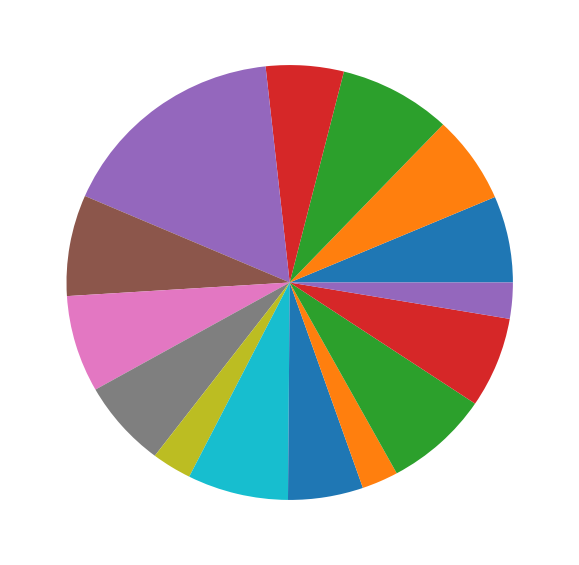

In [74]:
#plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(10,10))
plt.pie(cluster_size)
plt.show()

### Word2Vec
The beginning of an attemp to see if Word2Vec Might work

In [75]:
from nltk.tokenize import sent_tokenize, word_tokenize 
import warnings

In [81]:
sys.path = ['', '/anaconda3/lib/python36.zip', '/anaconda3/lib/python3.6', '/anaconda3/lib/python3.6/lib-dynload', '/anaconda3/lib/python3.6/site-packages', '/anaconda3/lib/python3.6/site-packages/aeosa']
import gensim 
from gensim.models import Word2Vec

In [114]:
#list_of_recipe_strings[0]
# train word2vec on the two sentences
w2vmodel = gensim.models.Word2Vec(list_of_ingredients, min_count=1)

In [115]:
w2vmodel.wv

In [117]:
newlist = []
avg = 0
for j in range(recipes_DF.shape[0]):
    count = 0
    for word in recipes_DF.iloc[j,0]:
        avg = avg + w2vmodel.wv.get_vector(word)
        count = count + 1
    newlist.append(avg/count)

In [119]:
len(newlist)

39774

In [106]:
w2vmodel.wv.similarity(recipes_DF.iloc[0,0][0], recipes_DF.iloc[0,0][1])

0.64206034

In [93]:
recipes_DF.iloc[0,0]

'pepper'

In [96]:
list_of_ingredients[0][0]

'pepper'